# Vision Transformer (ViT)

This example builds a vision transformer model using Equinox, an implementation based on the paper: An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale.


!!! cite "Reference"

    [arXiv link](https://arxiv.org/abs/2010.11929)

    ```bibtex
    @article{dosovitskiy2020image,
        title={An image is worth 16x16 words: Transformers for image recognition at scale},
        author={Dosovitskiy, Alexey and Beyer, Lucas and Kolesnikov, Alexander and Weissenborn, Dirk and Zhai, Xiaohua and Unterthiner, Thomas and Dehghani, Mostafa and Minderer, Matthias and Heigold, Georg and Gelly, Sylvain and others},
        journal={arXiv preprint arXiv:2010.11929},
        year={2020}
    }
    ```

In [1]:
from typing import List
import functools

import numpy as np

import einops

import jax
import jax.numpy as jnp
import jax.random as jr
import optax

# We'll use PyTorch to load the dataset.
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

import equinox as eqx

In [29]:
# Hyperparameters
lr = 0.0002
dropout_rate = 0.2
beta1 = 0.9
beta2 = 0.999
batch_size = 32
patch_size = 4
num_patches = 64
num_steps = 500000
image_size = (64, 64, 1)
embedding_dim = 512
hidden_dim = 256
num_heads = 12
num_layers = 12
height, width, channels = image_size

In [3]:
# Load the MNIST dataset using torchvision
transform = transforms.Compose(
    [
        transforms.Resize((height, width)),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,)),
    ]
)

train_dataset = torchvision.datasets.MNIST(
    "MNIST",
    train=True,
    download=True,
    transform=transform,
)

test_dataset = torchvision.datasets.MNIST(
    "MNIST",
    train=False,
    download=True,
    transform=transform,
)

trainloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True
)

testloader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size, shuffle=True
)

Let's load some example data, and see some sample MNIST digits.

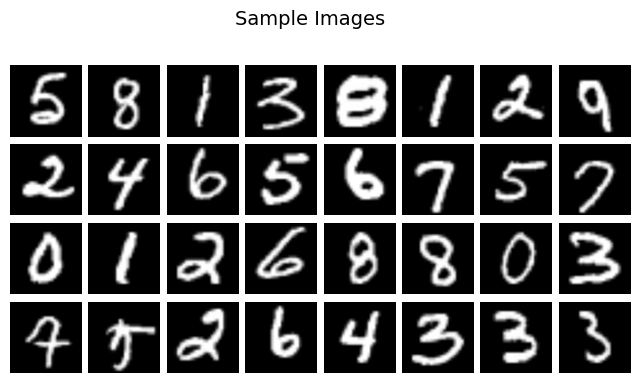

In [4]:
images, labels = next(iter(trainloader))

plot_sample = images.permute(0, 2, 3, 1)

fig, axes = plt.subplots(nrows=4, ncols=8, figsize=(8, 4))
fig.suptitle("Sample Images", y=1.02, fontsize=14)

for ax, image in zip(sum(axes.tolist(), []), plot_sample):
    ax.imshow(image, cmap="gray")
    ax.set_axis_off()

plt.subplots_adjust(wspace=0.1, hspace=0.1)
plt.show()

Now Let's start by making the patch embeddings layer that will turn images into embedded patches to be processed then by the attention layers.

In [5]:
class PatchEmbedding(eqx.Module):
    linear: eqx.nn.Embedding
    patch_size: int

    def __init__(
        self,
        input_channels: int,
        output_shape: int,
        patch_size: int,
        key: jr.PRNGKey,
    ):
        self.patch_size = patch_size

        self.linear = eqx.nn.Linear(
            self.patch_size**2 * input_channels,
            output_shape,
            key=key,
        )

    def __call__(self, x):
        x = einops.rearrange(
            x,
            "c (h ph) (w pw) -> (h w) (c ph pw)",
            ph=self.patch_size,
            pw=self.patch_size,
        )
        x = jax.vmap(self.linear)(x)  # [H'*W', D]

        return x

After that, we implement the attention block which is the core of the transformer architecture.

In [6]:
class AttentionBlock(eqx.Module):
    layer_norm: eqx.nn.LayerNorm
    attention: eqx.nn.MultiheadAttention
    linear1: eqx.nn.Sequential
    linear2: eqx.nn.Sequential
    dropout: eqx.nn.Dropout

    def __init__(
        self,
        input_shape: int,
        hidden_dim: int,
        num_heads: int,
        dropout_rate: float,
        key: jr.PRNGKey,
    ):
        keys = jr.split(key, 3)

        self.layer_norm = eqx.nn.LayerNorm(input_shape)
        self.attention = eqx.nn.MultiheadAttention(num_heads, input_shape, key=keys[0])

        self.linear1 = eqx.nn.Linear(input_shape, hidden_dim, key=keys[1])
        self.dropout = eqx.nn.Dropout(dropout_rate)
        self.linear2 = eqx.nn.Linear(hidden_dim, input_shape, key=keys[2])

    def __call__(self, x, enable_dropout, key):
        input_x = self.layer_norm(x)
        x = x + self.attention(input_x, input_x, input_x)

        input_x = self.layer_norm(x)
        input_x = jax.vmap(self.linear1)(input_x)
        input_x = jax.nn.gelu(input_x)

        keys = jr.split(key, num=2)

        input_x = self.dropout(input_x, inference=not enable_dropout, key=keys[0])
        input_x = jax.vmap(self.linear2)(input_x)
        input_x = self.dropout(input_x, inference=not enable_dropout, key=keys[1])

        x = x + input_x

        return x

Lastly, we build the full Vision Transformer model, which is composed of embeddings layers, a series of transformer blocks, and a classification head.

In [7]:
class VisionTransformer(eqx.Module):
    patch_embedding: PatchEmbedding
    positional_embedding: jax.Array
    cls_token: jax.Array
    attention_blocks: List[AttentionBlock]
    dropout: eqx.nn.Dropout
    mlp: eqx.nn.Sequential

    def __init__(
        self,
        embedding_dim: int,
        hidden_dim: int,
        num_heads: int,
        num_layers: int,
        dropout_rate: float,
        patch_size: int,
        num_patches: int,
        num_classes: int,
        key: jr.PRNGKey,
    ):
        keys = jr.split(key, 5)

        self.patch_embedding = PatchEmbedding(
            channels, embedding_dim, patch_size, keys[0]
        )

        self.positional_embedding = jr.normal(keys[1], (num_patches + 1, embedding_dim))

        self.cls_token = jr.normal(keys[2], (1, embedding_dim))

        self.attention_blocks = [
            AttentionBlock(embedding_dim, hidden_dim, num_heads, dropout_rate, keys[3])
            for _ in range(num_layers)
        ]

        self.dropout = eqx.nn.Dropout(dropout_rate)

        self.mlp = eqx.nn.Sequential(
            [
                eqx.nn.LayerNorm(embedding_dim),
                eqx.nn.Linear(embedding_dim, num_classes, key=keys[4]),
            ]
        )

    def __call__(self, x, enable_dropout, key):
        x = self.patch_embedding(x)

        x = jnp.concatenate((self.cls_token, x), axis=0)

        x = x + self.positional_embedding[x.shape[0]]

        key, subkey = jr.split(key)

        x = self.dropout(x, inference=not enable_dropout, key=subkey)

        for block in self.attention_blocks:
            key, subkey = jr.split(key)
            x = block(x, enable_dropout, key=subkey)

        x = x[0]
        x = self.mlp(x)

        return x

In [30]:
@eqx.filter_value_and_grad
def compute_grads(
    model: VisionTransformer, images: jnp.ndarray, labels: jnp.ndarray, key
):
    logits = jax.vmap(model, in_axes=(0, None, 0))(images, True, key)
    loss = optax.softmax_cross_entropy_with_integer_labels(logits, labels)

    return jnp.mean(loss)


@eqx.filter_jit
def step_model(
    model: VisionTransformer,
    optimizer: optax.GradientTransformation,
    state: optax.OptState,
    images: jnp.ndarray,
    labels: jnp.ndarray,
    key,
):
    loss, grads = compute_grads(model, images, labels, key)
    updates, new_state = optimizer.update(grads, state, model)

    model = eqx.apply_updates(model, updates)

    return model, new_state, loss


def train(
    model: VisionTransformer,
    optimizer: optax.GradientTransformation,
    state: optax.OptState,
    data_loader: torch.utils.data.DataLoader,
    num_steps: int,
    print_every: int = 1000,
    key=None,
):
    losses = []

    def infinite_trainloader():
        while True:
            yield from data_loader

    for step, batch in zip(range(num_steps), infinite_trainloader()):
        images, labels = batch

        images = images.numpy()
        labels = labels.numpy()

        key, *subkeys = jr.split(key, num=batch_size + 1)
        subkeys = jnp.array(subkeys)

        (model, state, loss) = step_model(
            model, optimizer, state, images, labels, subkeys
        )

        losses.append(loss)

        if (step % print_every) == 0 or step == num_steps - 1:
            print(f"Step: {step}/{num_steps}, Loss: {loss}.")

    return model, state, losses

In [ ]:
key = jr.PRNGKey(2003)

model = VisionTransformer(
    embedding_dim=embedding_dim,
    hidden_dim=hidden_dim,
    num_heads=num_heads,
    num_layers=num_layers,
    dropout_rate=dropout_rate,
    patch_size=patch_size,
    num_patches=num_patches,
    num_classes=10,
    key=key,
)

optimizer = optax.adamw(
    learning_rate=lr,
    b1=beta1,
    b2=beta2,
)

state = optimizer.init(eqx.filter(model, eqx.is_array))

model, state, losses = train(model, optimizer, state, trainloader, num_steps, key=key)

And now let's see how the vision transformer performs on the MNIST dataset.

In [25]:
accuracies = []

for batch in range(len(test_dataset) // batch_size):
    images, labels = next(iter(testloader))

    logits = jax.vmap(functools.partial(model, enable_dropout=False))(
        images.numpy(), key=jax.random.split(key, num=batch_size)
    )

    predictions = jnp.argmax(logits, axis=-1)

    accuracy = jnp.mean(predictions == labels.numpy())

    accuracies.append(accuracy)

print(f"Accuracy: {np.sum(accuracies) / len(accuracies) * 100}%")

Accuracy: 97.5%
